# Introduction

Hello dear researcher. We continue our series on YOLO where we left off. I have previously shown you how to train YOLO using your own dataset on YOLOv7, YOLOv8, YOLOv9 and YOLOv10 and how to make predictions with the trained model at the end of training. In this work, I will focus on YOLOv11 and will experiment on this version, just like in our previous YOLO studies. Previous YOLO studies can also be placed under this section. I hope you like my work. I wish you a good day and good work.

YOLO Works:
- [YoloV7](https://www.kaggle.com/code/ihsncnkz/face-mask-detection-with-yolov7)
- [YoloV8](https://www.kaggle.com/code/ihsncnkz/face-mask-detection-with-yolov8)
- [YoloV9](https://www.kaggle.com/code/ihsncnkz/face-mask-detection-with-yolov9)
- [YoloV10](https://www.kaggle.com/code/ihsncnkz/face-mask-detection-with-yolov10)

My Social Media Adress:
- [Linkedin](https://www.linkedin.com/in/ihsancenkiz/)
- [GitHub](https://github.com/ihsncnkz)

# Content <a id = 'cont'></a>
- [Data Review](#1)
- [Preparing Data](#2)
- [Preparing Training Data](#3)
- [YoloV10](#4)
- [Detection](#5)
- [CONCLUSION](#6)

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 13.4 MB/s eta 0:00:00


In [2]:
# Python librarys
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import xml.etree.cElementTree as ET
import glob
import os
import json
import random
import shutil

from PIL import Image, ImageOps

## Data Review <a id = '1'></a>
[Go Content](#cont)<br>
I will review the face mask data.

In [3]:
# This is a label from the annotation folder. This label is .xml format.
with open('/kaggle/input/face-mask-detection/annotations/maksssksksss116.xml') as f:
    contents = f.read()
    print(contents)


<annotation>
    <folder>images</folder>
    <filename>maksssksksss116.png</filename>
    <size>
        <width>400</width>
        <height>225</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>116</xmin>
            <ymin>88</ymin>
            <xmax>150</xmax>
            <ymax>122</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>160</xmin>
            <ymin>79</ymin>
            <xmax>193</xmax>
            <ymax>118</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</trunc

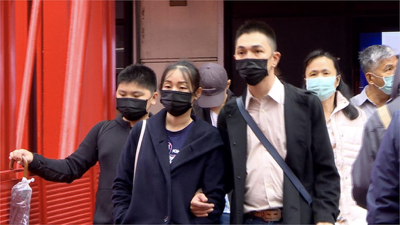

In [4]:
# This is image from the images folder.
Image.open("/kaggle/input/face-mask-detection/images/maksssksksss116.png")

In [5]:
with open('/kaggle/input/face-mask-detection/annotations/maksssksksss144.xml') as f:
    contents = f.read()
    print(contents)


<annotation>
    <folder>images</folder>
    <filename>maksssksksss144.png</filename>
    <size>
        <width>400</width>
        <height>217</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>130</xmin>
            <ymin>19</ymin>
            <xmax>155</xmax>
            <ymax>47</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>212</xmin>
            <ymin>56</ymin>
            <xmax>232</xmax>
            <ymax>79</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncat

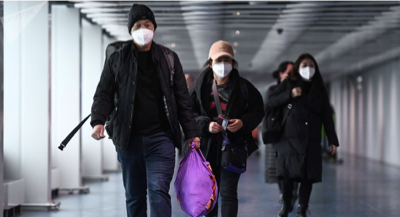

In [6]:
Image.open("/kaggle/input/face-mask-detection/images/maksssksksss144.png")

# Preparing Data <a id = '2'></a>
[Go Content](#cont)<br>
The data labels in our ready data set are in .xml format, we will convert this data to labels in .txt format.

In [7]:
# Preparing Data For Model(YoloV11)
# I will use these functions for .xml to .txt format.
def xml_to_yolo_bbox(bbox, w, h):
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h

    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h

    return [x_center, y_center, width, height]

def yolo_to_xml_bbox(bbox, w, h):
    w_half_len = (bbox[2] + w) / 2
    h_half_len = (bbox[3] + h) / 2

    xmin = int((bbox[0] + w) - w_half_len)
    ymin = int((bbox[1] + h) - h_half_len)
    xmax = int((bbox[0] + w) + w_half_len)
    ymax = int((bbox[1] + h) + h_half_len)

    return[xmin, ymin, xmax, ymax]

In [8]:
# Conversion phase
classes = []

input_dir = '/kaggle/input/face-mask-detection/annotations'
output_dir = '/kaggle/working/labels'
image_dir = '/kaggle/input/face-mask-detection/images'

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

files = glob.glob(os.path.join(input_dir, '*.xml'))
for fil in files:
    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]
    if not os.path.exists(os.path.join(image_dir, f'{filename}.png')):
        print(f'{filename} image does not exist')
        continue

    result = []

    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find('size').find('width').text)
    height = int(root.find('size').find('height').text)

    for obj in root.findall('object'):
        label = obj.find('name').text

        if label not in classes:
            classes.append(label)

        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find('bndbox')]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)

        bbox_string =  ' '.join([str(x) for x in yolo_bbox])
        result.append(f'{index} {bbox_string}')

    if result:
        with open(os.path.join(output_dir, f'{filename}.txt'), 'w', encoding = 'utf-8') as f:
            f.write('\n'.join(result))

with open(f'{output_dir}/classes.txt', 'w', encoding = 'utf-8') as f:
    f.write(json.dumps(classes))

In [9]:
# Lables
with open(f'{output_dir}/classes.txt') as f:
    contents = f.read()
    print(contents)

["with_mask", "mask_weared_incorrect", "without_mask"]


In [10]:
# .xml format
with open("/kaggle/input/face-mask-detection/annotations/maksssksksss174.xml") as f:
    contents = f.read()
    print(contents)


<annotation>
    <folder>images</folder>
    <filename>maksssksksss174.png</filename>
    <size>
        <width>400</width>
        <height>272</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>44</xmin>
            <ymin>63</ymin>
            <xmax>95</xmax>
            <ymax>117</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>102</xmin>
            <ymin>60</ymin>
            <xmax>142</xmax>
            <ymax>104</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncat

In [11]:
# .txt format
with open("/kaggle/working/labels/maksssksksss174.txt") as f:
    contents = f.read()
    print(contents)

0 0.17375 0.33088235294117646 0.1275 0.19852941176470587
0 0.305 0.3014705882352941 0.1 0.16176470588235295
0 0.5575 0.2647058823529412 0.135 0.20588235294117646
0 0.92875 0.2867647058823529 0.1025 0.17647058823529413


In [12]:
annotation_count = len(os.listdir("/kaggle/input/face-mask-detection/annotations"))
labels_count = len(os.listdir("/kaggle/working/labels"))
print(f"Annotation Counts: {annotation_count}")
print(f"Lables Counts: {labels_count}")

Annotation Counts: 853
Lables Counts: 854


## Preparing Training Data<a id = '3'></a>
[Go Content](#cont)<br>
I will prepare the training data for YOLOv11 in this chapter.

In [13]:
# Create a folder of train dataset
if not os.path.isfile("/kaggle/working/data"):
    os.mkdir('/kaggle/working/data')
    os.mkdir('/kaggle/working/data/train')
    os.mkdir('/kaggle/working/data/val')
    os.mkdir('/kaggle/working/data/test')
    os.mkdir('/kaggle/working/data/train/images')
    os.mkdir('/kaggle/working/data/train/labels')
    os.mkdir('/kaggle/working/data/test/images')
    os.mkdir('/kaggle/working/data/test/labels')
    os.mkdir('/kaggle/working/data/val/images')
    os.mkdir('/kaggle/working/data/val/labels')

In [14]:
# Material is the names of images in the images folder.
metarial = []
for i in os.listdir("/kaggle/input/face-mask-detection/images"):
    str = i[:-4]
    metarial.append(str)

In [15]:
metarial[0:10]

['maksssksksss810',
 'maksssksksss848',
 'maksssksksss145',
 'maksssksksss825',
 'maksssksksss30',
 'maksssksksss323',
 'maksssksksss805',
 'maksssksksss613',
 'maksssksksss315',
 'maksssksksss295']

In [16]:
print("Sum of image: ", len(metarial))
train_size = int(len(metarial) * 0.7)
test_size = int(len(metarial) * 0.15)
val_size = int(len(metarial) * 0.15)
print("Sum of the train size: ", train_size)
print("Sum of the test size: ", test_size)
print("Sum of the val size: ", val_size)

Sum of image:  853
Sum of the train size:  597
Sum of the test size:  127
Sum of the val size:  127


In [17]:
# The function is create train_data for YoloV11.
def preparinbdata(main_txt_file, main_img_file, train_size, test_size, val_size):
    for i in range(0, train_size):
        source_txt = main_txt_file + "/" + metarial[i] + ".txt"
        source_img = main_img_file + "/" + metarial[i] + ".png"
        
        mstring = metarial[i]
        train_destination_txt = "/kaggle/working/data/train/labels" + "/" + metarial[i] + ".txt"
        train_destination_png = "/kaggle/working/data/train/images" + "/" + metarial[i] + ".png"
        
        shutil.copy(source_txt, train_destination_txt)
        shutil.copy(source_img, train_destination_png)
        
    for l in range(train_size , train_size + test_size):

        source_txt = main_txt_file + "/" + metarial[l] + ".txt"
        source_img = main_img_file + "/" + metarial[l] + ".png"

        mstring = metarial[l]
        test_destination_txt = "/kaggle/working/data/test/labels" + "/" + metarial[l] + ".txt"
        test_destination_png = "/kaggle/working/data/test/images" + "/" + metarial[l] + ".png"

        shutil.copy(source_txt, test_destination_txt)
        shutil.copy(source_img, test_destination_png)

        #metarial.remove(file_name[:-4])


    for n in range(train_size + test_size , train_size + test_size + val_size):

        source_txt = main_txt_file + "/" + metarial[n] + ".txt"
        source_img = main_img_file + "/" + metarial[n] + ".png"

        mstring = metarial[n]
        val_destination_txt = "/kaggle/working/data/val/labels" + "/" + metarial[n] + ".txt"
        val_destination_png = "/kaggle/working/data/val/images" + "/" + metarial[n] + ".png"

        shutil.copy(source_txt, val_destination_txt)
        shutil.copy(source_img, val_destination_png)
        

In [18]:
#preparinbdata("/kaggle/working/labels", "/kaggle/input/face-mask-detection/images", 597, 127, 127)
preparinbdata(main_txt_file = "/kaggle/working/labels", 
              main_img_file = "/kaggle/input/face-mask-detection/images",
              train_size = train_size,
              test_size = test_size, 
              val_size = val_size)

In [19]:
# Create the data.yaml. I am going to use it on the train with yolov9.
yaml_text = """train: /kaggle/working/data/train/images/
val: /kaggle/working/data/val/images/

nc: 3
names: ["with_mask", "mask_weared_incorrect", "without_mask"]"""

with open("/kaggle/working/data/data.yaml", 'w') as file:
    file.write(yaml_text)

In [20]:
with open("/kaggle/working/data/data.yaml") as f:
    contents = f.read()
    print(contents)

train: /kaggle/working/data/train/images/
val: /kaggle/working/data/val/images/

nc: 3
names: ["with_mask", "mask_weared_incorrect", "without_mask"]


## YoloV11<a id = '4'></a>
[Go Content](#cont)<br>
YOLOv11, built on the Ultralytics Python package by researchers at Tsinghua University, introduces a new approach to real-time object detection. We can train and predict with our data with YOLOv11. YOLOv11 is an image detection models. If you want to learn about YOLOv10, [please click here There is so much information about YOLOv10 in this link.](https://docs.ultralytics.com/models/yolo11/). 

In [21]:
# We should close wandb because If we don't close wandb we can't start training.
import wandb
wandb.init(mode='disabled')

In [22]:
# Training 
from ultralytics import YOLO

model = YOLO('yolo11n.pt')

results = model.train(data="/kaggle/working/data/data.yaml", epochs=50, imgsz=640, save = True, device = [0])

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 21.3MB/s]


Ultralytics 8.3.27 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/data/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

100%|██████████| 755k/755k [00:00<00:00, 4.56MB/s]
2024-11-03 14:37:47,243	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-03 14:37:47,745	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/data/train/labels... 597 images, 0 backgrounds, 0 corrupt: 100%|██████████| 597/597 [00:01<00:00, 447.31it/s]

train: New cache created: /kaggle/working/data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/data/val/labels... 127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 127/127 [00:00<00:00, 309.62it/s]


val: New cache created: /kaggle/working/data/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.65G      2.191      4.058      1.807        113        640:  39%|███▉      | 15/38 [00:04<00:05,  3.94it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       1/50       3.1G      1.801      3.026      1.388         46        640: 100%|██████████| 38/38 [00:10<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

                   all        127        651     0.0168       0.64      0.222      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.69G      1.394      1.643      1.042        119        640:  37%|███▋      | 14/38 [00:03<00:05,  4.48it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       2/50      2.74G      1.381      1.597      1.055         33        640: 100%|██████████| 38/38 [00:08<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.43it/s]

                   all        127        651      0.955     0.0896      0.241      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.86G      1.297      1.427      1.068         85        640:  53%|█████▎    | 20/38 [00:04<00:03,  4.73it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       3/50       2.9G      1.284      1.355      1.066         38        640: 100%|██████████| 38/38 [00:08<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.37it/s]

                   all        127        651      0.551      0.253       0.34      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.72G      1.335       1.26      1.038        122        640:  13%|█▎        | 5/38 [00:01<00:07,  4.60it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       4/50      2.78G      1.275      1.232      1.057         17        640: 100%|██████████| 38/38 [00:08<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


                   all        127        651        0.5      0.453      0.469      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.62G      1.241      1.156      1.028        160        640:  34%|███▍      | 13/38 [00:02<00:05,  4.43it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       5/50      2.84G       1.23      1.136      1.038         33        640: 100%|██████████| 38/38 [00:08<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.51it/s]

                   all        127        651      0.676      0.507      0.553      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.76G      1.239      1.103      1.026        156        640:  45%|████▍     | 17/38 [00:03<00:04,  4.65it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       6/50      2.81G      1.226      1.081      1.024         53        640: 100%|██████████| 38/38 [00:08<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.59it/s]


                   all        127        651      0.864      0.511      0.578       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.64G      1.183      1.016      1.012        131        640:  61%|██████    | 23/38 [00:04<00:03,  4.74it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       7/50      2.69G      1.177      1.015      1.014         40        640: 100%|██████████| 38/38 [00:08<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.32it/s]

                   all        127        651      0.557       0.56      0.574      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.65G      1.182     0.9798      1.013        154        640:  66%|██████▌   | 25/38 [00:05<00:02,  4.68it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       8/50      2.96G      1.201     0.9921      1.024         29        640: 100%|██████████| 38/38 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


                   all        127        651      0.645      0.532      0.573      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.65G       1.24     0.9793      1.023        103        640:  32%|███▏      | 12/38 [00:02<00:05,  4.70it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       9/50      2.88G      1.198     0.9465      1.017         41        640: 100%|██████████| 38/38 [00:08<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


                   all        127        651      0.725      0.616      0.649        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.63G      1.147     0.9064      1.008        104        640:  50%|█████     | 19/38 [00:04<00:04,  4.51it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      10/50      2.69G      1.154     0.8976      1.005         46        640: 100%|██████████| 38/38 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


                   all        127        651      0.633      0.615      0.608      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.79G      1.129      0.872     0.9861        110        640:  66%|██████▌   | 25/38 [00:05<00:02,  4.53it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      11/50      3.39G      1.138     0.8764     0.9924         29        640: 100%|██████████| 38/38 [00:08<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


                   all        127        651      0.667      0.609      0.646      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.77G      1.125     0.8486     0.9948        130        640:  63%|██████▎   | 24/38 [00:05<00:03,  4.67it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      12/50      2.83G      1.124     0.8565     0.9932         29        640: 100%|██████████| 38/38 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

                   all        127        651      0.745      0.584      0.646       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/38 [00:00<?, ?it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      13/50      2.83G       1.12     0.8171      0.991         30        640: 100%|██████████| 38/38 [00:08<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


                   all        127        651      0.619      0.592      0.628      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/38 [00:00<?, ?it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      14/50      2.82G      1.126     0.8019     0.9966         27        640: 100%|██████████| 38/38 [00:08<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


                   all        127        651      0.654      0.672      0.661       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.66G      1.119     0.8023      0.991        191        640:  76%|███████▋  | 29/38 [00:06<00:02,  4.48it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      15/50      2.71G       1.12     0.7931     0.9888         19        640: 100%|██████████| 38/38 [00:08<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]

                   all        127        651      0.744      0.557      0.661      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.84G      1.166     0.8221     0.9893         83        640:  55%|█████▌    | 21/38 [00:04<00:03,  4.59it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      16/50      2.89G      1.142     0.8118     0.9903         23        640: 100%|██████████| 38/38 [00:08<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]

                   all        127        651      0.726      0.673      0.699      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.89G      1.131      0.779      0.989        152        640:  61%|██████    | 23/38 [00:05<00:03,  3.97it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      17/50      2.94G      1.099     0.7591     0.9794         44        640: 100%|██████████| 38/38 [00:08<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.89it/s]

                   all        127        651      0.688       0.66      0.688      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.62G      1.072     0.7345      0.978        105        640:  66%|██████▌   | 25/38 [00:05<00:02,  4.68it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      18/50      2.68G       1.08     0.7402     0.9733         94        640: 100%|██████████| 38/38 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.24it/s]

                   all        127        651      0.782      0.628      0.694      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.68G      1.114     0.7383     0.9799        110        640:  32%|███▏      | 12/38 [00:02<00:05,  4.77it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      19/50      2.73G        1.1     0.7292     0.9781         39        640: 100%|██████████| 38/38 [00:08<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.95it/s]

                   all        127        651      0.799      0.619      0.742      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.75G      1.068       0.71     0.9721        164        640:  42%|████▏     | 16/38 [00:03<00:04,  4.63it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      20/50      2.81G      1.073     0.7118     0.9713         28        640: 100%|██████████| 38/38 [00:08<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.06it/s]

                   all        127        651      0.631      0.651      0.628      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.67G      1.059     0.6974      0.965         52        640: 100%|██████████| 38/38 [00:08<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.96it/s]

                   all        127        651      0.675      0.708      0.677      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.65G      1.048     0.6768     0.9713        144        640:  71%|███████   | 27/38 [00:05<00:02,  4.36it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      22/50      2.65G      1.067     0.6899     0.9726        176        640:  87%|████████▋ | 33/38 [00:07<00:01,  4.66it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      22/50      2.71G      1.066     0.7044     0.9711          9        640: 100%|██████████| 38/38 [00:08<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.85it/s]

                   all        127        651      0.854      0.696       0.77      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.85G      1.047     0.6882     0.9673         29        640: 100%|██████████| 38/38 [00:08<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]

                   all        127        651      0.753      0.698      0.757      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.62G      1.109     0.7002     0.9533        105        640:   8%|▊         | 3/38 [00:00<00:08,  4.27it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      24/50      2.87G      1.055     0.6704     0.9607         25        640: 100%|██████████| 38/38 [00:08<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.79it/s]

                   all        127        651      0.777      0.689      0.771      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.84G      1.067     0.6733     0.9672        190        640:  92%|█████████▏| 35/38 [00:07<00:00,  4.67it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      25/50      2.89G      1.062     0.6749      0.967         22        640: 100%|██████████| 38/38 [00:08<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.95it/s]

                   all        127        651      0.803      0.684      0.754      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.89G      1.026     0.6461     0.9572         68        640: 100%|██████████| 38/38 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

                   all        127        651      0.816      0.689      0.772      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.83G      1.073     0.6621     0.9637         98        640:  39%|███▉      | 15/38 [00:03<00:05,  4.34it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      27/50      2.88G      1.022     0.6434     0.9586         31        640: 100%|██████████| 38/38 [00:08<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.04it/s]

                   all        127        651      0.795      0.665      0.764      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       2.7G      0.984     0.6392     0.9545         61        640:  11%|█         | 4/38 [00:00<00:07,  4.70it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      28/50      2.75G      1.027     0.6422      0.952         64        640: 100%|██████████| 38/38 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]

                   all        127        651      0.694       0.72      0.716      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.63G      1.011     0.6053     0.9493        112        640:  39%|███▉      | 15/38 [00:03<00:04,  4.64it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      29/50      2.79G      1.023       0.62     0.9512        110        640:  87%|████████▋ | 33/38 [00:07<00:01,  4.50it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      29/50      2.84G      1.011     0.6189     0.9507         38        640: 100%|██████████| 38/38 [00:08<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.93it/s]

                   all        127        651       0.91      0.703      0.795      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.71G      1.005     0.6238     0.9533         55        640: 100%|██████████| 38/38 [00:08<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.95it/s]

                   all        127        651      0.756      0.705      0.758      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.61G      1.007      0.607     0.9443        112        640:  55%|█████▌    | 21/38 [00:04<00:03,  4.45it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      31/50      2.66G      1.001     0.6049     0.9462         56        640: 100%|██████████| 38/38 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.96it/s]

                   all        127        651      0.804      0.713      0.764      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.84G      1.017     0.6059     0.9497         16        640: 100%|██████████| 38/38 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.01it/s]

                   all        127        651      0.787      0.705      0.776      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.62G     0.9895     0.5866     0.9409        101        640:  11%|█         | 4/38 [00:00<00:07,  4.75it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      33/50      2.81G     0.9798     0.5799     0.9489         36        640: 100%|██████████| 38/38 [00:08<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.91it/s]

                   all        127        651      0.851      0.737      0.803      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.62G     0.9999     0.5626     0.9384        160        640:   3%|▎         | 1/38 [00:00<00:07,  4.70it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      34/50      2.67G     0.9829     0.5904     0.9401         28        640: 100%|██████████| 38/38 [00:08<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.92it/s]

                   all        127        651      0.899      0.694      0.791      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.81G      1.015      0.607     0.9469        175        640:  53%|█████▎    | 20/38 [00:04<00:03,  4.71it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      35/50      2.86G     0.9875     0.5931     0.9384         26        640: 100%|██████████| 38/38 [00:08<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.87it/s]

                   all        127        651      0.743      0.731      0.769      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.62G      1.039     0.6116     0.9439        135        640:   5%|▌         | 2/38 [00:00<00:07,  5.00it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      36/50      2.82G     0.9645     0.5658     0.9452         24        640: 100%|██████████| 38/38 [00:08<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        127        651      0.847      0.691      0.794      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.96G     0.9809      0.583     0.9358         84        640:  76%|███████▋  | 29/38 [00:06<00:01,  4.52it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      37/50      3.01G     0.9907     0.5793     0.9349         79        640: 100%|██████████| 38/38 [00:08<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]

                   all        127        651      0.844      0.676      0.773      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.65G     0.9857      0.563     0.9354        132        640:  13%|█▎        | 5/38 [00:01<00:06,  4.72it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      38/50      2.71G     0.9502     0.5489     0.9311         43        640: 100%|██████████| 38/38 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.00it/s]

                   all        127        651      0.876      0.661      0.776      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.83G      1.002     0.5691     0.9458        105        640:  55%|█████▌    | 21/38 [00:04<00:03,  4.49it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      39/50      2.83G     0.9918     0.5665     0.9441        103        640:  82%|████████▏ | 31/38 [00:06<00:01,  4.69it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      39/50      2.88G     0.9828     0.5652     0.9406        102        640: 100%|██████████| 38/38 [00:08<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


                   all        127        651      0.887      0.667      0.789       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       2.9G      0.947     0.5633     0.9284         15        640: 100%|██████████| 38/38 [00:08<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.12it/s]

                   all        127        651       0.83      0.723      0.787      0.535


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/38 [00:00<?, ?it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      41/50      2.76G     0.9361       0.54     0.9218         41        640: 100%|██████████| 38/38 [00:09<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

                   all        127        651      0.747      0.744      0.773      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.65G     0.9243     0.4982     0.9112         69        640:  39%|███▉      | 15/38 [00:03<00:05,  4.46it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      42/50       2.7G     0.9358     0.5117     0.9096         15        640: 100%|██████████| 38/38 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]

                   all        127        651      0.815      0.708      0.784      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       2.7G     0.9353     0.5096     0.9016         62        640:  29%|██▉       | 11/38 [00:02<00:06,  4.21it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      43/50       2.7G     0.9193     0.5066     0.9106         52        640:  95%|█████████▍| 36/38 [00:08<00:00,  4.88it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      43/50      2.75G     0.9319     0.5149     0.9117         84        640: 100%|██████████| 38/38 [00:08<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.18it/s]

                   all        127        651      0.912      0.678      0.806       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.67G       0.91     0.4981     0.9068         86        640:  84%|████████▍ | 32/38 [00:06<00:01,  4.73it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      44/50      2.73G     0.9212     0.5029      0.911         28        640: 100%|██████████| 38/38 [00:08<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]

                   all        127        651      0.754      0.709      0.769      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.76G     0.8893     0.4882       0.91         10        640: 100%|██████████| 38/38 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.01it/s]

                   all        127        651      0.788      0.703       0.79      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.67G     0.9118     0.4998     0.9183        116        640:  42%|████▏     | 16/38 [00:03<00:04,  4.56it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      46/50      2.72G     0.9085     0.4936     0.9115         19        640: 100%|██████████| 38/38 [00:08<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.93it/s]

                   all        127        651      0.835      0.699       0.79       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.77G     0.8911     0.4781     0.8974         50        640:  50%|█████     | 19/38 [00:04<00:04,  4.71it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      47/50      2.82G     0.8998     0.4856      0.904         20        640: 100%|██████████| 38/38 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.90it/s]

                   all        127        651      0.836      0.735      0.799      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.61G     0.9108     0.4788     0.9035        129        640:  66%|██████▌   | 25/38 [00:05<00:02,  4.64it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      48/50      2.67G       0.89     0.4754     0.9001         16        640: 100%|██████████| 38/38 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.58it/s]

                   all        127        651      0.835      0.743      0.801      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.71G     0.9006     0.4788     0.9076         20        640: 100%|██████████| 38/38 [00:08<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.27it/s]

                   all        127        651      0.853      0.697      0.788      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.68G     0.8968     0.4758     0.9077         99        640:  76%|███████▋  | 29/38 [00:06<00:01,  4.79it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      50/50      2.73G     0.8759     0.4669     0.9058         17        640: 100%|██████████| 38/38 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.89it/s]

                   all        127        651      0.872      0.698      0.793      0.542



50 epochs completed in 0.142 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


                   all        127        651      0.835      0.743      0.799      0.543
             with_mask        116        500      0.927      0.859      0.919      0.614
 mask_weared_incorrect         19         24      0.694      0.583      0.611      0.474
          without_mask         51        127      0.885      0.788      0.867       0.54
Speed: 0.1ms preprocess, 2.6ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train


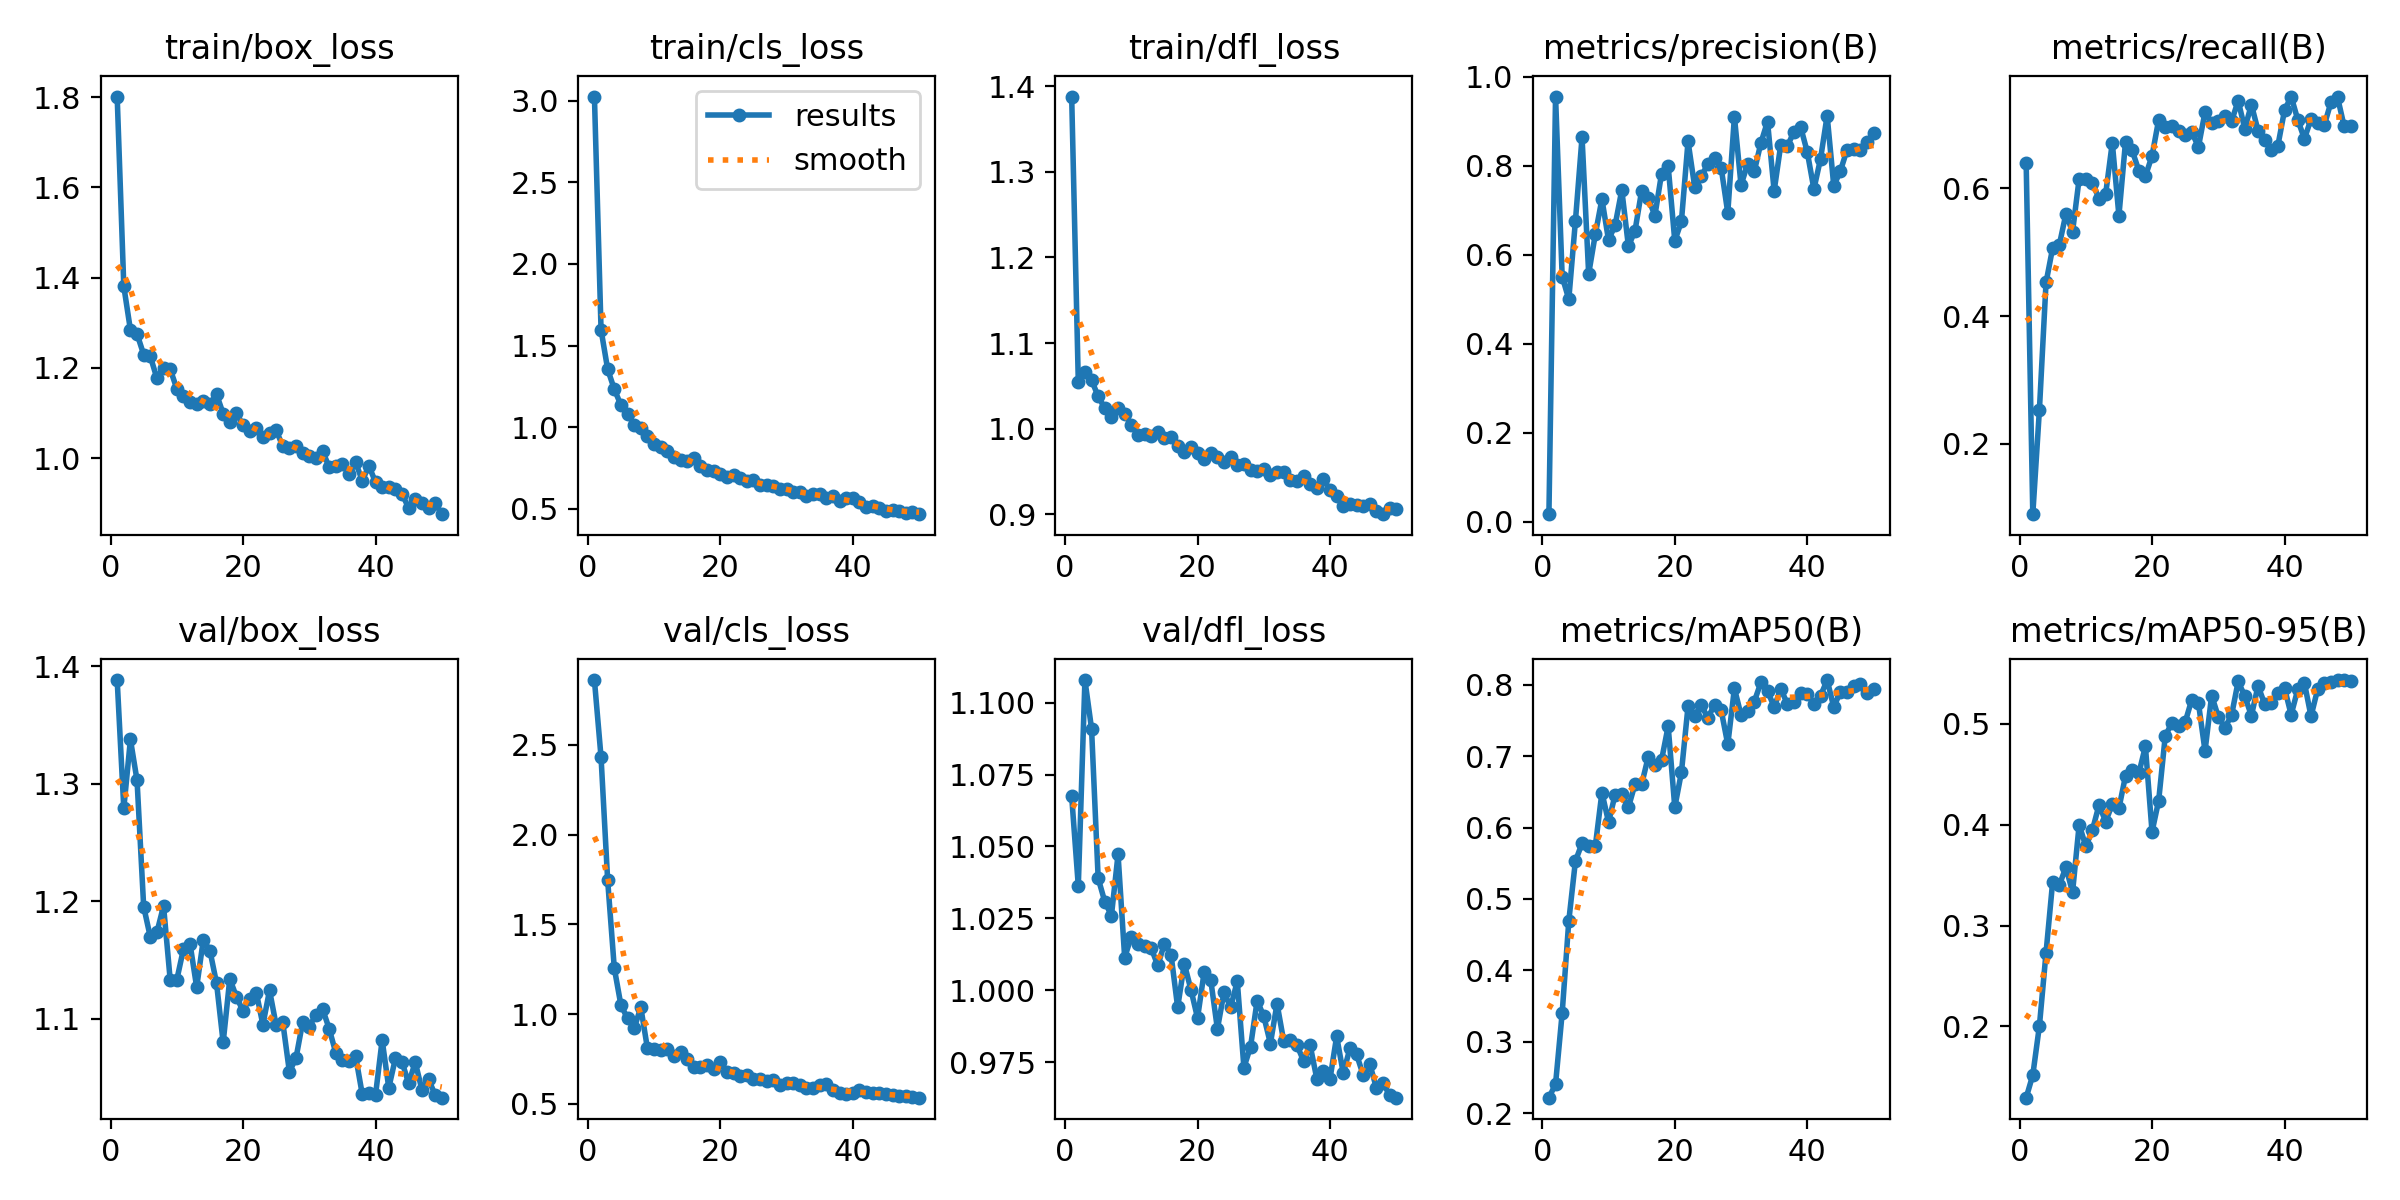

In [23]:
# Training result image
Image.open("/kaggle/working/runs/detect/train/results.png")

The values ​​in the result image are stable and in this 50-step training we performed, there were decreases in train_loss and val_loss values, which is a good situation. At the same time, the increase in metrics_precision, recall, mAP50, and mAP50-95 values ​​is also a good situation.

Detailed Analysis of the Graphs
- Train Loss:
    - Box Loss: Represents the error rate in predicting the bounding boxes of objects. As training progresses, this value generally decreases, indicating that your model is becoming better at predicting the locations of objects.
    - Cls Loss: Represents the error rate in classifying objects. This value also decreases as training progresses, indicating that your model is becoming better at correctly classifying objects.
    - Dfl Loss: This loss function represents the error rate in predicting the size and shape of objects. The decrease in dfl loss as training progresses indicates that your model is becoming better at predicting the size of objects.

- Validation Loss: Used to evaluate the generalizability of the results obtained on the training set on a previously unseen dataset (validation set). It is normal for the validation loss to be higher than the training loss, but the difference between the two is expected to decrease as training progresses. This is generally observed in the graphs.
  
- Metrics:
    - Precision: Represents the ratio of true positive predictions to total positive predictions. A high precision value indicates that the model has few false positive predictions.
    - Recall: Represents the ratio of true positive predictions to all actual positive examples. A high recall value indicates that the model is able to correctly find most of the true positive examples.
    - mAP (Mean Average Precision): It is the average of the average precision values calculated at different IoU (Intersection over Union) thresholds. The mAP value is a comprehensive metric used to evaluate the overall performance of the model. The increase in mAP50 and mAP50-95 values as training progresses indicates that your model's object detection performance is improving.

# Detection<a id='5'></a>
[Go Content](#cont)<br>
I will detect this with our model.

In [24]:
# We will perform the detection process using the weights that the model we trained achieved the best result in 50 steps of training.
model_predict = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")

In [25]:
# Detection 1
model_predict.predict("/kaggle/working/data/test/images/maksssksksss451.png", save=True)


image 1/1 /kaggle/working/data/test/images/maksssksksss451.png: 448x640 11 with_masks, 3 without_masks, 46.3ms
Speed: 1.7ms preprocess, 46.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'with_mask', 1: 'mask_weared_incorrect', 2: 'without_mask'}
 obb: None
 orig_img: array([[[156, 156, 187],
         [ 34,  35,  54],
         [ 11,  15,  23],
         ...,
         [ 85,  67, 104],
         [ 89,  71, 109],
         [ 88,  70, 109]],
 
        [[182, 181, 212],
         [ 50,  50,  67],
         [ 12,  14,  19],
         ...,
         [ 81,  66,  96],
         [ 83,  68, 101],
         [ 83,  68, 103]],
 
        [[185, 185, 216],
         [ 94,  94, 110],
         [  6,   7,  10],
         ...,
         [ 73,  64,  77],
         [ 73,  63,  82],
         [ 76,  66,  89]],
 
        ...,
 
        [[ 40,  58,  98],
         [ 41,  58, 100],
         [ 43,  57, 100],
         ...,
         [ 27,  26,  28],
         [ 20,  15,  16],
         [ 13,   8,   9]],
 
        [[ 36,  57,  93],
         [ 39,  57,  96],
        

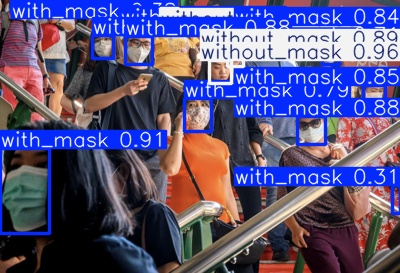

In [26]:
# Detection 1 Result
Image.open("/kaggle/working/runs/detect/predict/maksssksksss451.jpg")

In [27]:
# Download Image
!wget "https://onecms-res.cloudinary.com/image/upload/s--XV7DHKzY--/c_fill,g_auto,h_468,w_830/f_auto,q_auto/people-wearing-mask-at-orchard-road-singapore-feb-3--49-.jpg?itok=GdDk1T6A"

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-11-03 14:47:01--  https://onecms-res.cloudinary.com/image/upload/s--XV7DHKzY--/c_fill,g_auto,h_468,w_830/f_auto,q_auto/people-wearing-mask-at-orchard-road-singapore-feb-3--49-.jpg?itok=GdDk1T6A
Resolving onecms-res.cloudinary.com (onecms-res.cloudinary.com)... 184.85.108.42, 2600:1417:76:194::523, 2600:1417:76:192::523
Connecting to onecms-res.cloudinary.com (onecms-res.cloudinary.com)|184.85.108.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44288 (43K) [image/jpeg]
Saving to: 'people-wearing-mask-at-orchard-road-singapore-feb-3--49-.jpg?itok=GdDk1T6A'

people-wearing-mask 100%[===================>]  43.25K  --.-KB/s    in 0.004s  

2024-11-03 14:47:01 (10.5 MB/s) - 'people-wearing-mask-at-orchard-road-singapore-feb-3--49-.jpg?itok=GdDk1T6A' saved [44288/44288]



In [28]:
# Rename image
os.rename("/kaggle/working/people-wearing-mask-at-orchard-road-singapore-feb-3--49-.jpg?itok=GdDk1T6A", "image.jpg")

In [29]:
# Detection 2
model_predict.predict("/kaggle/working/image.jpg", save=True) 


image 1/1 /kaggle/working/image.jpg: 384x640 2 with_masks, 5 without_masks, 54.5ms
Speed: 2.3ms preprocess, 54.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'with_mask', 1: 'mask_weared_incorrect', 2: 'without_mask'}
 obb: None
 orig_img: array([[[ 41,  52,  50],
         [ 41,  52,  50],
         [ 38,  51,  49],
         ...,
         [156, 145, 131],
         [147, 136, 122],
         [141, 130, 116]],
 
        [[ 41,  52,  50],
         [ 41,  52,  50],
         [ 38,  51,  49],
         ...,
         [155, 144, 130],
         [146, 135, 121],
         [139, 128, 114]],
 
        [[ 41,  52,  50],
         [ 41,  52,  50],
         [ 38,  51,  49],
         ...,
         [153, 142, 128],
         [144, 133, 119],
         [137, 126, 112]],
 
        ...,
 
        [[227, 197, 180],
         [227, 197, 180],
         [226, 196, 179],
         ...,
         [147, 145, 144],
         [143, 141, 140],
         [140, 138, 137]],
 
        [[227, 197, 180],
         [227, 197, 180],
        

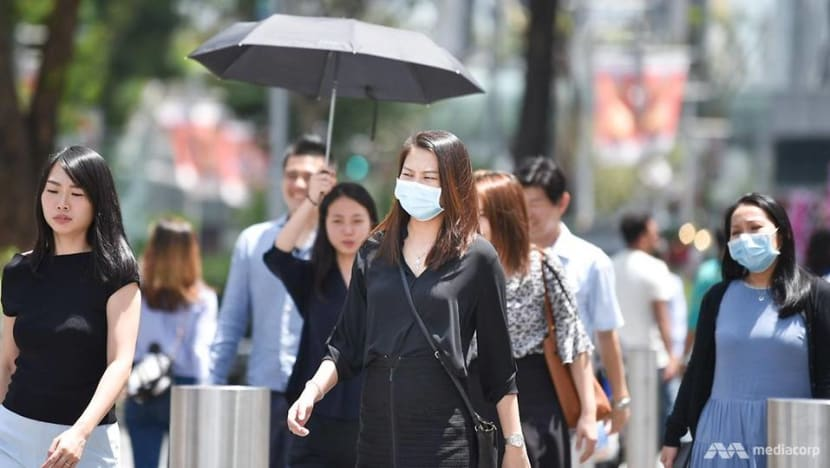

In [30]:
# Original image
Image.open("/kaggle/working/image.jpg")

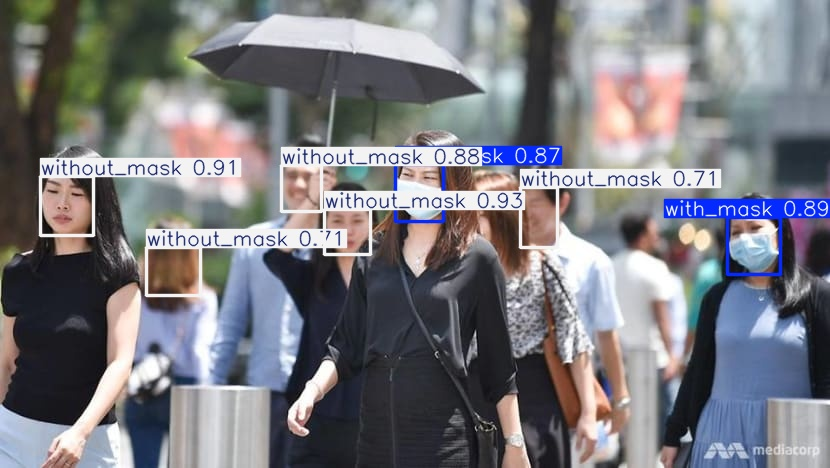

In [31]:
# Detection 2 Result
Image.open("/kaggle/working/runs/detect/predict/image.jpg")

# CONCLUSION <a id='6'></a>
[Go Content](#cont)
Thank you for reviewing my project this far. I hope this has been a project for you that sheds light on your path and expands your horizons. About to be selected for new projects!

![](https://media.tenor.com/s-J6vqs61fkAAAAC/bye-pikachu.gif)